#The Price of Basic Goods


---
**CS146 LBA** 

Marcela Radilla Deloya 

In [235]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.stats as sts

## Data Preprocessing

In [236]:
# I a lot of preprocessing in google sheets which was dropping all the names, emails, addresses, converting the currency, and normalizing the prices.
dataset = pd.read_csv('https://raw.githubusercontent.com/marcelaradilla/cs146/a1f148c65ba17534d0bcbf900c40ed684ce0941f/LBA_data_clean1.csv')

In [237]:
dataset.head()

,Country,Store,Perception,Rent,P1M1,P1M2,P1M3,P2M1,P2M2,P2M3,P3M1,P3M2,P3M3,P4M1,P4M2,P4M3,P5M1,P5M2,P5M3,P6M1,P6M2,P6M3,P7M1,P7M2,P7M3,P8M1,P8M2,P8M3,P9M1,P9M2,P9M3,P10M1,P10M2,P10M3
0,Germany,EDEKA,Mid-range,1071.00,3.4867,1.9159,2.082500,2.0587,2.0587,0.0000,5.80125,5.331200,3.37960,0.571200,0.624750,1.148350,2.0825,1.4994,1.8564,9.2820,6.7354,5.819100,1.7374,1.2495,1.4875,10.2340,10.1864,9.9960,0.751683,0.347083,0.592025,15.141987,7.675500,8.627500
1,Germany,EDEKA,Mid-range,1011.50,2.3205,3.4867,4.358375,2.0587,1.3209,2.0587,3.37960,5.807200,5.75960,1.293133,1.293133,3.570000,1.1543,1.5946,2.0825,5.8072,7.7588,11.622333,0.9044,1.7374,1.8564,8.5680,10.9956,7.4256,0.581117,0.541450,0.193970,15.161929,19.842558,34.896463
2,Germany,EDEKA,Mid-range,1190.00,3.4867,1.4875,2.034900,2.7965,1.7374,0.0000,2.28480,11.622333,13.94680,0.868700,1.743350,2.320500,1.1305,0.4522,1.7374,6.1761,2.2967,5.128900,0.9044,2.0944,1.4637,13.1376,6.4736,13.9468,0.290360,0.384370,0.148750,7.695333,8.657250,0.000000
3,Germany,Alnatura,Luxury (expensive),1190.00,4.7481,4.7481,4.748100,2.7251,0.0000,0.0000,9.40100,7.128100,11.78100,2.963100,2.969050,3.564050,1.7731,1.1305,1.7731,4.7481,7.1281,9.151100,1.7731,1.5351,1.3685,14.2324,11.8524,12.3284,0.510510,0.236810,0.535500,39.151000,0.000000,0.000000
4,Germany,EDEKA,Budget (cheap),1065.05,3.4867,3.4867,3.486700,2.0587,1.3209,4.6172,7.25900,5.759600,5.80125,0.928200,2.320500,0.464893,0.4403,0.9044,1.0234,5.8072,7.7588,4.569600,0.8449,0.0000,0.0000,9.9960,6.6045,10.5672,0.581117,0.483933,0.278460,7.675500,15.148214,11.649850


We will now reshape the dataset to have one row per price observation, meaning that for each row of the original dataset, we will take the first 4 columns, make 30 copies of it, and for each row (1:30) we will add the price observation. We will keep track of which column those observations are coming from so that we add an extra column for what kind of product that observation is coming from. 

In [238]:
#in this cell we iterate through the 64 responses to the form and we add the price from each of the 30 price columns to each of the rows. 
all_data = []
for i in range(64):
  for j in range(30):
    all_data.append(np.concatenate((dataset.iloc[i][:4], [dataset.iloc[i][4:][j]], [dataset.iloc[i][4:].index[j][1:-2]])))
    #to encode the product column, we take from the second character to the character that is before the last two (the third to last).
    #example: from the column title P1M1, [1:-2], takes only 1. 
#in the end we have a dataframe with the colums: 'country','store','perception','rent','price','product' 
df = pd.DataFrame(all_data, columns=['country','store','perception','rent','price','product'])

In [239]:
#making sure that we have no repetitions 
#NOTE: The store named Market was given because a student did not put the name of the store and it did not come up 
#when we looked the address up on Google Maps
np.unique(df.store)

array(['ALDI', 'Albertsons', 'Alnatura', 'Big C', 'Carrefour', 'Chung cu',
       'Coupang', 'EDEKA', 'Epicerie', 'Foodsco', 'Grocery Outlet',
       'Latorre', 'Lidl', 'Marjane', 'Market', 'Nam An', 'REWE',
       'Safeway', 'Sainsburys', 'Smiths', 'Target', 'Tesco',
       'Trader Joes', 'Vons', 'Waitrose', 'Walmart', 'Whole Foods'],
      dtype=object)

In [240]:
np.unique(df.country)

array(['Germany', 'Guatemala', 'Morocco', 'South Korea', 'UK', 'USA',
       'Vietnam'], dtype=object)

We will now encode the country and the perception characteristics into numbers in a column. 

In [241]:
df['perception_code'] = pd.factorize(df['perception'], sort=True)[0] + 1
df['country_code'] = pd.factorize(df['country'], sort=True)[0] + 1

In [242]:
df

,country,store,perception,rent,price,product,perception_code,country_code
0,Germany,EDEKA,Mid-range,1071.0,3.486700,1,3,1
1,Germany,EDEKA,Mid-range,1071.0,1.915900,1,3,1
2,Germany,EDEKA,Mid-range,1071.0,2.082500,1,3,1
3,Germany,EDEKA,Mid-range,1071.0,2.058700,2,3,1
4,Germany,EDEKA,Mid-range,1071.0,2.058700,2,3,1
...,...,...,...,...,...,...,...,...
1915,Vietnam,Chung cu,Mid-range,500.0,0.111667,9,3,7
1916,Vietnam,Chung cu,Mid-range,500.0,0.111667,9,3,7
1917,Vietnam,Chung cu,Mid-range,500.0,4.480000,10,3,7
1918,Vietnam,Chung cu,Mid-range,500.0,3.800000,10,3,7


In [243]:
#from google sheets, all missing observations were replaced with zero
#we are now removing all missing observations, knowing that we are not removing 
#anything that is actually zero because there are no zeros as price observations
df = df[(df != 0).all(1)]

In [244]:
df

,country,store,perception,rent,price,product,perception_code,country_code
0,Germany,EDEKA,Mid-range,1071.0,3.486700,1,3,1
1,Germany,EDEKA,Mid-range,1071.0,1.915900,1,3,1
2,Germany,EDEKA,Mid-range,1071.0,2.082500,1,3,1
3,Germany,EDEKA,Mid-range,1071.0,2.058700,2,3,1
4,Germany,EDEKA,Mid-range,1071.0,2.058700,2,3,1
...,...,...,...,...,...,...,...,...
1915,Vietnam,Chung cu,Mid-range,500.0,0.111667,9,3,7
1916,Vietnam,Chung cu,Mid-range,500.0,0.111667,9,3,7
1917,Vietnam,Chung cu,Mid-range,500.0,4.480000,10,3,7
1918,Vietnam,Chung cu,Mid-range,500.0,3.800000,10,3,7


In [245]:
df_cleancopy=df

In [246]:
#checking that we have no zeroes in our data
np.min(df.price)

0.00143

In [247]:
#the product column was made from strings, we make it all integers 
df['product'] = df['product'].apply(lambda x: int(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [248]:
df['product'].values

array([ 1,  1,  1, ..., 10, 10, 10])

Plotting the data to look at the range of prices and outliers. 

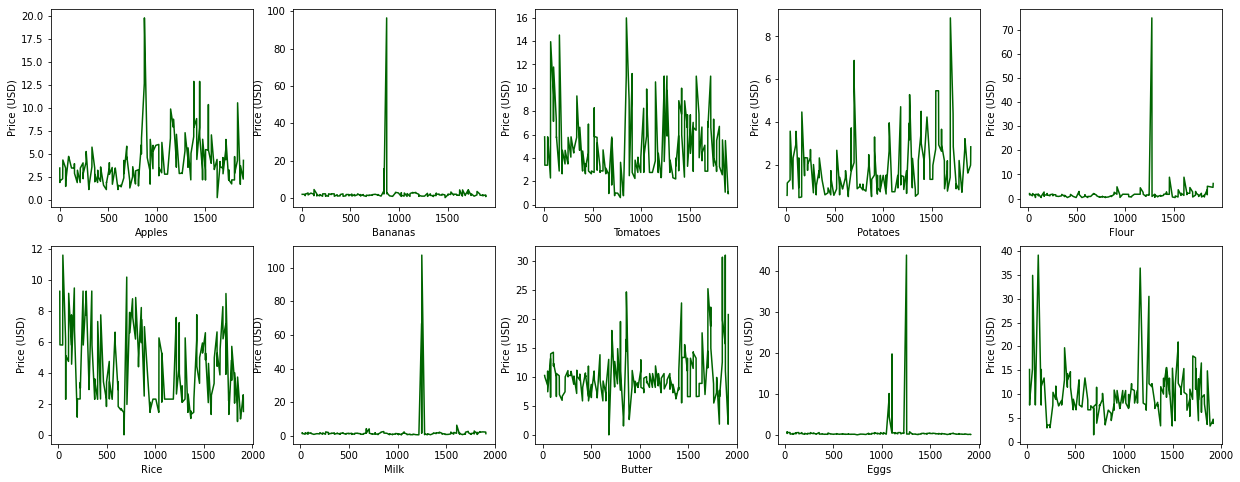

In [249]:
products=['Apples','Bananas','Tomatoes','Potatoes','Flour','Rice','Milk','Butter','Eggs','Chicken']
prods=[1,2,3,4,5,6,7,8,9,10]
mins=[]
maxs=[]
fig, axs = plt.subplots(2, 5, figsize=(21,8))
x=0
for line in range(2):
  for el in range(5):
    axs[line,el].plot(df.loc[df['product'] == prods[x]]['price'], color='darkgreen')  
    mins.append(np.min(df.loc[df['product'] == prods[x]]['price']))
    maxs.append(np.max(df.loc[df['product'] == prods[x]]['price']))
    #print(x)
    axs[line,el].set_xlabel(products[x])
    axs[line,el].set_ylabel('Price (USD)')
    x=x+1
  x=5

As we can see there are some very extreme outliers, my guess is there are due to errors when plugging data collected into the form. It will be really hard to go through all of the outliers and remove them, and removing data is also adding bias to the analysis, so I will try my best to remove those that are completely unrealistic and that in my opinion are probably due to error. 


In [250]:
print('Mins:',mins)
print('Maxs:',maxs)

Mins: [0.2725450902, 0.3044244295, 0.605, 0.4648933333, 0.40645, 0.00143, 0.5814977974000001, 0.012208695649999999, 0.0275, 1.42727385]
Maxs: [19.8, 96.36, 15.9844, 8.866666667, 74.844, 11.62233333, 107.448, 30.96, 43.956, 39.150999999999996]


In [251]:
#I am removing this price for bananas because it is just unrealistic, and because there are also other observations from Sainsbury's that have bananas, and are nowhere near 96.36 USD
df.loc[df['price'] == 96.36]

,country,store,perception,rent,price,product,perception_code,country_code
873,UK,Sainsburys,Mid-range,1030.92,96.36,2,3,5


In [252]:
df.loc[870:875]

,country,store,perception,rent,price,product,perception_code,country_code
870,UK,Sainsburys,Mid-range,1030.92,12.672000,1,3,5
871,UK,Sainsburys,Mid-range,1030.92,12.672000,1,3,5
872,UK,Sainsburys,Mid-range,1030.92,19.800000,1,3,5
873,UK,Sainsburys,Mid-range,1030.92,96.360000,2,3,5
874,UK,Sainsburys,Mid-range,1030.92,2.346667,2,3,5
875,UK,Sainsburys,Mid-range,1030.92,2.904000,2,3,5


In [253]:
df=df.drop(873)

In [254]:
df.loc[870:875]

,country,store,perception,rent,price,product,perception_code,country_code
870,UK,Sainsburys,Mid-range,1030.92,12.672000,1,3,5
871,UK,Sainsburys,Mid-range,1030.92,12.672000,1,3,5
872,UK,Sainsburys,Mid-range,1030.92,19.800000,1,3,5
874,UK,Sainsburys,Mid-range,1030.92,2.346667,2,3,5
875,UK,Sainsburys,Mid-range,1030.92,2.904000,2,3,5


In [255]:
#also removing this price for flour from Waitrose
df.loc[df['price'] == 74.844]

,country,store,perception,rent,price,product,perception_code,country_code
1272,UK,Waitrose,Luxury (expensive),3003.0,74.844,5,2,5


In [256]:
df.loc[1269:1275]

,country,store,perception,rent,price,product,perception_code,country_code
1269,UK,Waitrose,Luxury (expensive),3003.0,3.9600,4,2,5
1270,UK,Waitrose,Luxury (expensive),3003.0,3.1680,4,2,5
1271,UK,Waitrose,Luxury (expensive),3003.0,5.2800,4,2,5
1272,UK,Waitrose,Luxury (expensive),3003.0,74.8440,5,2,5
1273,UK,Waitrose,Luxury (expensive),3003.0,1.5840,5,2,5
1274,UK,Waitrose,Luxury (expensive),3003.0,0.8844,5,2,5
1275,UK,Waitrose,Luxury (expensive),3003.0,2.1120,6,2,5


In [257]:
df=df.drop(1272)

In [258]:
#Taking out two milk outliers (107 and 66 USD)
df.loc[df['price'] == 107.448]

,country,store,perception,rent,price,product,perception_code,country_code
1250,UK,Waitrose,Luxury (expensive),3718.44,107.448,7,2,5


In [259]:
df.loc[1245:1257]

,country,store,perception,rent,price,product,perception_code,country_code
1245,UK,Waitrose,Luxury (expensive),3718.44,4.488,6,2,5
1246,UK,Waitrose,Luxury (expensive),3718.44,7.260,6,2,5
1247,UK,Waitrose,Luxury (expensive),3718.44,3.960,6,2,5
1248,UK,Waitrose,Luxury (expensive),3718.44,66.792,7,2,5
1249,UK,Waitrose,Luxury (expensive),3718.44,1.518,7,2,5
1250,UK,Waitrose,Luxury (expensive),3718.44,107.448,7,2,5
1251,UK,Waitrose,Luxury (expensive),3718.44,10.560,8,2,5
1252,UK,Waitrose,Luxury (expensive),3718.44,8.976,8,2,5
1253,UK,Waitrose,Luxury (expensive),3718.44,7.920,8,2,5
1254,UK,Waitrose,Luxury (expensive),3718.44,43.956,9,2,5


In [260]:
df=df.drop(1250)

In [261]:
df=df.drop(1248)

In [262]:
#egg outlier
df.loc[df['price'] == 43.956]

,country,store,perception,rent,price,product,perception_code,country_code
1254,UK,Waitrose,Luxury (expensive),3718.44,43.956,9,2,5


In [263]:
df=df.drop(1254)

In [264]:
df

,country,store,perception,rent,price,product,perception_code,country_code
0,Germany,EDEKA,Mid-range,1071.0,3.486700,1,3,1
1,Germany,EDEKA,Mid-range,1071.0,1.915900,1,3,1
2,Germany,EDEKA,Mid-range,1071.0,2.082500,1,3,1
3,Germany,EDEKA,Mid-range,1071.0,2.058700,2,3,1
4,Germany,EDEKA,Mid-range,1071.0,2.058700,2,3,1
...,...,...,...,...,...,...,...,...
1915,Vietnam,Chung cu,Mid-range,500.0,0.111667,9,3,7
1916,Vietnam,Chung cu,Mid-range,500.0,0.111667,9,3,7
1917,Vietnam,Chung cu,Mid-range,500.0,4.480000,10,3,7
1918,Vietnam,Chung cu,Mid-range,500.0,3.800000,10,3,7


We took 5 outlier values in total, we will now plot the data again. 

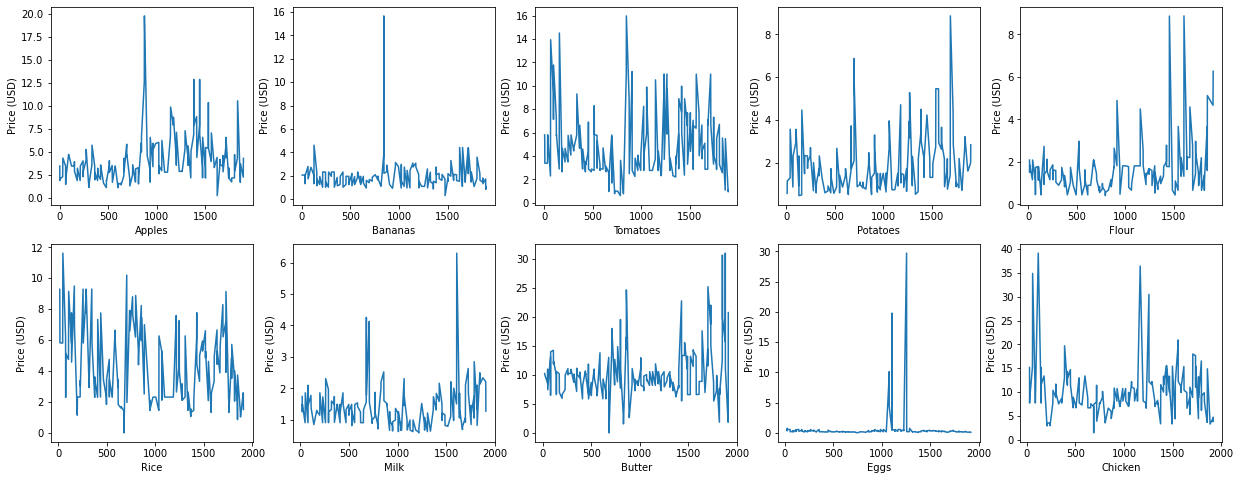

In [265]:
products=['Apples','Bananas','Tomatoes','Potatoes','Flour','Rice','Milk','Butter','Eggs','Chicken']
prods=[1,2,3,4,5,6,7,8,9,10]
mins=[]
maxs=[]
fig, axs = plt.subplots(2, 5, figsize=(21,8))
x=0
for line in range(2):
  for el in range(5):
    axs[line,el].plot(df.loc[df['product'] == prods[x]]['price'])  
    mins.append(np.min(df.loc[df['product'] == prods[x]]['price']))
    maxs.append(np.max(df.loc[df['product'] == prods[x]]['price']))
    #print(x)
    axs[line,el].set_xlabel(products[x])
    axs[line,el].set_ylabel('Price (USD)')
    x=x+1
  x=5

In [266]:
print('Mins:',mins)
print('Maxs:',maxs)

Mins: [0.2725450902, 0.3044244295, 0.605, 0.4648933333, 0.40645, 0.00143, 0.5814977974000001, 0.012208695649999999, 0.0275, 1.42727385]
Maxs: [19.8, 15.664000000000001, 15.9844, 8.866666667, 8.866666667, 11.62233333, 6.305263158, 30.96, 29.7, 39.150999999999996]


As we can see we still have some outliers but we do not want to remove anymore since we want to avoid adding a self-generated bias to the observations that we are working with. 

## Building the model


###Distributions: 
We will use a truncated Cauchy for the prior for the base price, since the fat tails of distribution allow for higher probabilities of values far away from the mean than the normal distribution. We also do not have particular prior knowledge about, we could have looked up average prices of each product, but this dataset includes information from different countries and different types of stores so we kept the prior not very informative. 

We will center the Cauchy around 5, assuming that most products cost around 5 USD. 

We will use Gamma priors for the country and store type multipliers. Since the mean is given my the multiplication of the location and scale parameters of the distribution, we can know that it will be centered around 1 if we set them at 2 and 0.5. We will also use a Gamma(1,1) for the error, this is only to derive the standard distribution for the likelihood, since I know that some of the outliers are due to human error. 

We will use a normal for the likelihood, setting the price to come from a normal distribution, whose mean is given by:  

$(base price)*$ $(country$ $multiplier)*$ $(store$ $multiplier)$

and whose standard deviation is given by the error, over which we are also computing a posterior. 

In [267]:
# We have to tell Stan what data to expect, what our parameters are and what
# the likelihood and prior are. Since the posterior is just proportional to
# the product of the likelihood and the prior, we don't distinguish between
# them explicitly in the model below. Every distribution we specify is
# automatically incorporated into the product of likelihood * prior.

stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  

  int<lower=0> n; //number of observations 
  int<lower=0> p; // number of products 
  int<lower=0> c; // number of countries 
  int<lower=1> s; // number of store types 
  real<lower=0> prices[n]; // this establishes an n-sized array containing real values named price 
  int<lower=1> products[n]; // an array of length p containing ints for the product types which are coded from 1 to 10 
  int<lower=1> countries[n]; // array of length containing ints for country codes 
  int<lower=1> stores[n]; // array of length containing the store type which is coded with perception_code


}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

  real<lower=0> base_price[p]; // an array with a base price for each product 
  real<lower=0> country_mult[c]; // an array with multipliers for each country 
  real<lower=0> store_mult[s];// an array with multipliers for each store type (cheap,expensive,midrange) 
  real<lower=0> error; // error for the likelihood (this is the sigma)

}

// The model block contains all probability distributions in the model.
// Think of this as specifying the generative model for the scenario.
model {
    //priors
    base_price~cauchy(5,5); // prior over the base price 
    country_mult~gamma(2,0.5); // prior over country multiplier with mean=1
    store_mult~gamma(2,0.5); //prior over store multiplier with mean=1
    error ~ gamma(1,1);
    //likelihood 
    for (i in 1:n){
      prices[i]~normal(base_price[products[i]]*country_mult[countries[i]]*store_mult[stores[i]], error);
    }
}

"""

In [268]:
#compiling Stan model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_48c5a5a4637074737e2ceedef0130919 NOW.


### Providing STAN with the data

In [269]:
#creating a dictionary with our dataset 
data={
    'n':len(df['price']),
    'p':len(np.unique(df['product'])),
    'c':len(np.unique(df['country'])),
    's':len(np.unique(df['perception_code'])),

    'prices':df['price'].values,
    'products':df['product'].values,
    'countries':df['country_code'].values,
    'stores':df['perception_code'].values
}
data

{'c': 7,
 'countries': array([1, 1, 1, ..., 7, 7, 7]),
 'n': 1756,
 'p': 10,
 'prices': array([3.4867, 1.9159, 2.0825, ..., 4.48  , 3.8   , 4.66  ]),
 'products': array([ 1,  1,  1, ..., 10, 10, 10]),
 's': 3,
 'stores': array([3, 3, 3, ..., 3, 3, 3])}

In [270]:
print(data)

{'n': 1756, 'p': 10, 'c': 7, 's': 3, 'prices': array([3.4867, 1.9159, 2.0825, ..., 4.48  , 3.8   , 4.66  ]), 'products': array([ 1,  1,  1, ..., 10, 10, 10]), 'countries': array([1, 1, 1, ..., 7, 7, 7]), 'stores': array([3, 3, 3, ..., 3, 3, 3])}


## Results
### STAN output

In [271]:
#stan output 
stan_results=stan_model.sampling(data=data)
samples=stan_results.extract()
print(stan_results)

Inference for Stan model: anon_model_48c5a5a4637074737e2ceedef0130919.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]     5.78    0.07   1.97   2.75   4.38   5.49   6.83  10.39    792   1.01
base_price[2]      2.8    0.03   0.99   1.29   2.09   2.66   3.34   5.14    846    1.0
base_price[3]     7.24    0.09   2.45   3.52   5.48   6.89   8.58  13.01    758   1.01
base_price[4]     2.67    0.03   0.94   1.24   2.01   2.53   3.19   4.93    828   1.01
base_price[5]     2.28    0.03   0.83   1.03   1.68   2.15   2.74   4.22    829   1.01
base_price[6]     6.11    0.07   2.08   2.96   4.64   5.78   7.26  11.04    804   1.01
base_price[7]     1.99    0.02   0.74   0.89   1.44   1.87   2.42   3.71    922    1.0
base_price[8]    14.02    0.17   4.74   6.78  10.63  13.28  16.59  24.98    773   1.01
base_price[9]     1.03    0.

### Base prices for each product

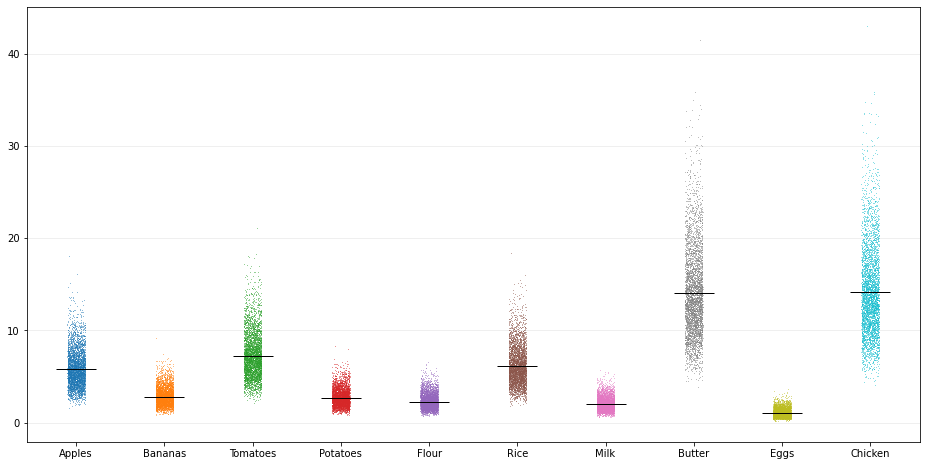

In [272]:
products_1=['Apples','Bananas','Tomatoes','Potatoes','Flour','Rice','Milk','Butter','Eggs','Chicken']
plt.figure(figsize=(16,8))
for i in range(10):
      #this part was taken from the code Prof. Scheffler shared with us on session 7.2 when we were modeling elections
      #I thought it was a great way to show Stan output
  plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['base_price'][:,i], ',', alpha=0.5)
  plt.xticks([0,1,2,3,4,5,6,7,8,9],products_1)

plt.plot(range(0, 10),samples['base_price'].mean(axis=0), marker='_',linewidth=0,color="black",alpha=1,markersize=40)
plt.grid(True, alpha=0.25, axis='y')
plt.show()

### Country multipliers

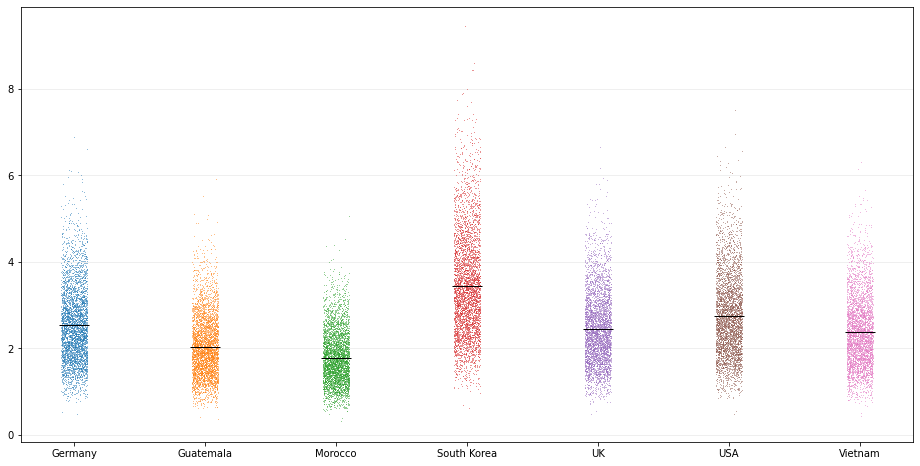

In [273]:
countries_1=np.unique(df.country)
plt.figure(figsize=(16,8))
for i in range(7):
      #this part was taken from the code Prof. Scheffler shared with us on session 7.2 when we were modeling elections
      #I thought it was a great way to show Stan output
  plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['country_mult'][:,i], ',', alpha=0.5)
  plt.xticks([0,1,2,3,4,5,6],countries_1)

plt.plot(range(0, 7),samples['country_mult'].mean(axis=0), marker='_',linewidth=0,color="black",alpha=1,markersize=30)
plt.grid(True, alpha=0.25, axis='y')
plt.show()

### Store perception multipliers

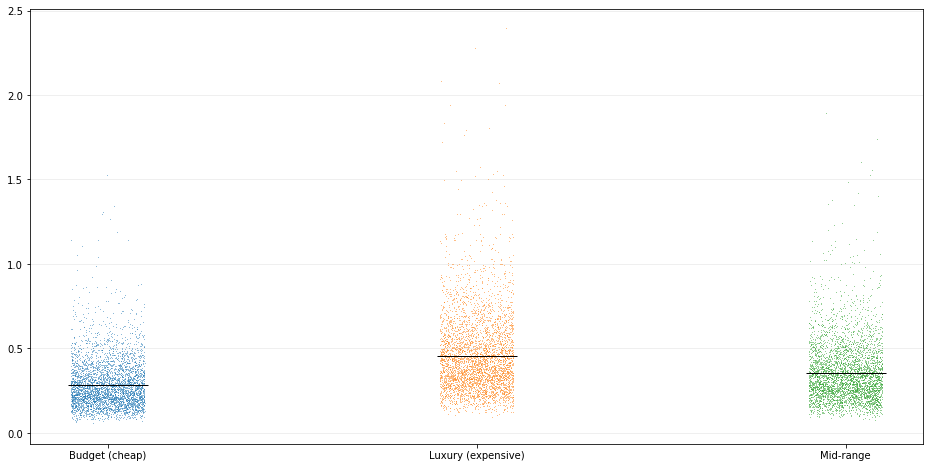

In [274]:
perceptions_1=np.unique(df.perception)
plt.figure(figsize=(16,8))
for i in range(3):
      #this part was taken from the code Prof. Scheffler shared with us on session 7.2 when we were modeling elections
      #I thought it was a great way to show Stan output
  plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['store_mult'][:,i], ',', alpha=0.5)
  plt.xticks([0,1,2],perceptions_1)

plt.plot(range(0, 3),samples['store_mult'].mean(axis=0), marker='_',linewidth=0,color="black",alpha=1,markersize=80)
plt.grid(True, alpha=0.25, axis='y')
plt.show()

### Rental prices 
In this section we focus on analyzing the correlation between the variation in price by geographical location and the variation in rental prices. We begin by taking the mean of the rental price data for each country. 

In [275]:
rental_prices=[]
for country in np.unique(df['country']):
  countryrental=np.mean(df.loc[df['country'] == country]['rent'].values)
  rental_prices.append(countryrental)
  print(country,':',countryrental)

Germany : 1077.8536438127092
Guatemala : 468.36725000000007
Morocco : 1015.3
South Korea : 471.7000000000001
UK : 2231.6217
USA : 2242.3847965738755
Vietnam : 817.0993192771085


In [276]:
rental_prices=np.asarray(rental_prices)
country_mult_means=samples['country_mult'].mean(axis=0)
c_matrix=np.corrcoef(rental_prices,country_mult_means)
c_matrix[0,1]

0.015983442301487252

In [277]:
#the correlation coefficient appears to be very small
#code inspired from a page on correlation and linear regression in python https://realpython.com/numpy-scipy-pandas-correlation-python/
slope, intercept, r, p, stderr = sts.linregress(rental_prices,country_mult_means)

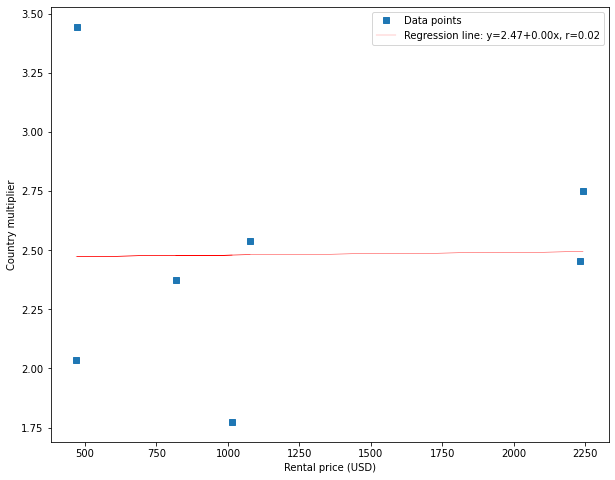

Correlation coefficient: 0.016 with p-value of 0.973


In [278]:
plt.figure(figsize=(10, 8))
plt.plot(rental_prices,country_mult_means,linewidth=0, marker='s', label='Data points')
plt.plot(rental_prices, intercept + slope * rental_prices, label=f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}',color='red',linewidth=.2)
#plt.plot(rental_prices, np.poly1d(np.polyfit(rental_prices, country_mult_means, 1))(rental_prices), color='r', linewidth=.2)
plt.legend()
plt.xlabel('Rental price (USD)')
plt.ylabel('Country multiplier')
plt.show()
print("Correlation coefficient: {} with p-value of {}".format(round(c_matrix[0,1],3), round(p,3)))

In [279]:
country_mult_means

array([2.54018833, 2.03723486, 1.77340949, 3.44589443, 2.45259   ,
       2.75081475, 2.37320951])

In [280]:
rental_prices

array([1077.85364381,  468.36725   , 1015.3       ,  471.7       ,
       2231.6217    , 2242.38479657,  817.09931928])

Based on the graph above, it seems that the datapoint in the upper left corner is driving the regression line to have a smaller slope, that datapoint is South Korea. As we can see South Korea has the largest multiplier, but it has almost the cheapest rent price. South Korea might be an example of a country where rent prices do not correlate with how expensive its groceries are. For the sole purpose of finding out, I want to look at the output of the correlation without the South Korea datapoint.

In [281]:
country_mult2=np.delete(country_mult_means,3)
country_mult2

array([2.54018833, 2.03723486, 1.77340949, 2.45259   , 2.75081475,
       2.37320951])

In [282]:
rental_prices2=np.delete(rental_prices,3)
rental_prices2

array([1077.85364381,  468.36725   , 1015.3       , 2231.6217    ,
       2242.38479657,  817.09931928])

In [283]:
c_matrix2=np.corrcoef(rental_prices2,country_mult2)
c_matrix2[0,1]

0.6338533619825264

In [284]:
slope1, intercept1, r1, p1, stderr1 = sts.linregress(rental_prices2,country_mult2)

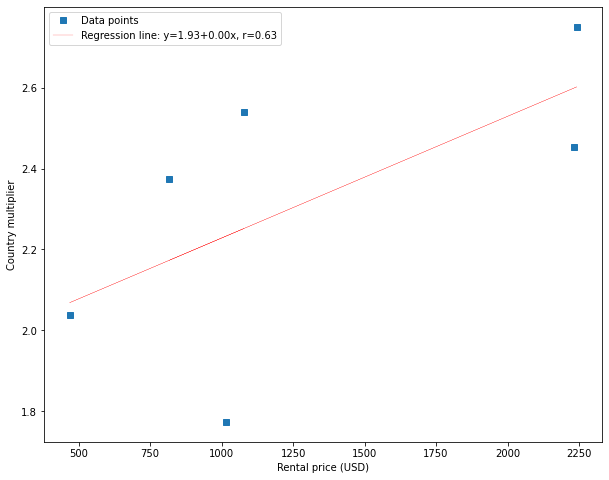

Correlation coefficient: 0.634 with p-value of 0.177


In [285]:
plt.figure(figsize=(10, 8))
plt.plot(rental_prices2,country_mult2,linewidth=0, marker='s', label='Data points')
plt.plot(rental_prices2, intercept1 + slope1 * rental_prices2, label=f'Regression line: y={intercept1:.2f}+{slope1:.2f}x, r={r1:.2f}',color='red',linewidth=.2)
#plt.plot(rental_prices, np.poly1d(np.polyfit(rental_prices, country_mult_means, 1))(rental_prices), color='r', linewidth=.2)
plt.legend()
plt.xlabel('Rental price (USD)')
plt.ylabel('Country multiplier')
plt.show()
print("Correlation coefficient: {} with p-value of {}".format(round(c_matrix2[0,1],3), round(p1,3)))

Without the South Korea datapoint, we have a correlation of 0.6 which is pretty good, however, we still will report the main outcome which is the negative correlation, because while it is true that it correlates for these countries, South Korea is an exception to the rule.